# African Airlines Sentiment Analysis (2015-Present)
**Data Cleaning & Preprocessing**

### 1. Library Importation

In [93]:
#Packages for data loading and manipulation
import pandas as pd
from glob import glob
import numpy as np
from datetime import datetime as dt

#Visualization packages
import seaborn as sns
import missingno
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline

#Packages for text cleaning
from cleantext.cleantext import clean
import nltk
nltk.download('stopwords') 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/koredeakande/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 2. Loading the data 

In [94]:
filepath = r'../data/raw' #File path with all data for the respective airlines
all_files = glob(filepath + "/*.csv") #Reference all the files

#List to store the files as dataframes
files_list = []

#Iterating through all the files
for filename in all_files:
    
    #Read the csv and append to the files_list
    df = pd.read_csv(filename,index_col=0)
    files_list.append(df)

#Form a merged dataframe with data on all airlines
airlines_df = pd.concat(files_list, axis=0, ignore_index=True)

In [95]:
airlines_df.head()

,Subject,date_published,verified,review_text,aircraft,type_of_traveller,seat_type,route,date_flown,seat_comfort,cabin_staff_service,food_&_beverages,inflight_entertainment,ground_service,wifi_&_connectivity,value_for_money,recommended
0,ethiopian-airlines,2021-01-31 00:08:00,True,I've flown Ethiopian Airlines a couple of time...,Boeing 777,Business,Economy Class,Addis Ababa to Washington,August 2021,2.0,1.0,1.0,1.0,2.0,1.0,1.0,no
1,ethiopian-airlines,2021-01-06 00:08:00,True,Fantastic journey. Flew on a Q400 turbo prop f...,Q400 / A350-900,Solo Leisure,Economy Class,Khartoum to Kilimanjaro via Addis Ababa,July 2021,5.0,5.0,5.0,5.0,5.0,NaN,5.0,yes
2,ethiopian-airlines,2021-01-29 00:07:00,True,My children are stuck in transit in Ethiopia a...,NaN,Family Leisure,Economy Class,Kilimanjaro to Johannesburg via Addis Ababa,July 2021,1.0,1.0,1.0,1.0,1.0,1.0,1.0,no
3,ethiopian-airlines,2021-01-17 00:07:00,False,"Average to below average. Dirty, dated 767 on ...",Boeing 767,Business,Economy Class,Johannesburg to Addis Ababa,July 2021,1.0,2.0,2.0,1.0,1.0,NaN,3.0,no
4,ethiopian-airlines,2021-01-10 00:07:00,True,Due to cancellation of my KQ flight EBB-NBO-JN...,NaN,Solo Leisure,Business Class,Entebbe to Johannesburg via Addis Ababa,June 2021,4.0,4.0,3.0,2.0,2.0,NaN,3.0,yes


In [96]:
print(airlines_df.shape)

(1256, 17)


### 3. Exploratory Data Analysis (EDA) for cleaning

In [97]:
profile = ProfileReport(airlines_df, title="African Airlines Profiling Report", explorative=True)

In [98]:
profile

Summarize dataset:   0%|          | 0/30 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
profile.to_file("../reports/african_airlines_eda_report.html")

In [99]:
airlines_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Subject                 1256 non-null   object 
 1   date_published          1256 non-null   object 
 2   verified                894 non-null    object 
 3   review_text             1256 non-null   object 
 4   aircraft                639 non-null    object 
 5   type_of_traveller       1170 non-null   object 
 6   seat_type               1256 non-null   object 
 7   route                   1170 non-null   object 
 8   date_flown              1170 non-null   object 
 9   seat_comfort            1184 non-null   float64
 10  cabin_staff_service     1179 non-null   float64
 11  food_&_beverages        1110 non-null   float64
 12  inflight_entertainment  882 non-null    float64
 13  ground_service          1127 non-null   float64
 14  wifi_&_connectivity     226 non-null    

### 4. Data Cleaning & Reformatting

#### a. Data Type Conversion

In [100]:
#Convert data published column to datetime object
airlines_df.date_published = pd.to_datetime(airlines_df.date_published)

#Convert recommended to integer (yes = 1 and no = 0). This will be helpful for ML algorithms
airlines_df.recommended = airlines_df.recommended.map({'yes':1, 'no': 0}, na_action = 'ignore')

#### b. Exploring & Handling missing data
Deleting Unnecessary Columns. These have high missingness and are deemed to not be contributing important info

In [101]:
#Delete verified, route, and aircraft columns
airlines_df = airlines_df.drop(columns = ['verified','route', 'aircraft'])

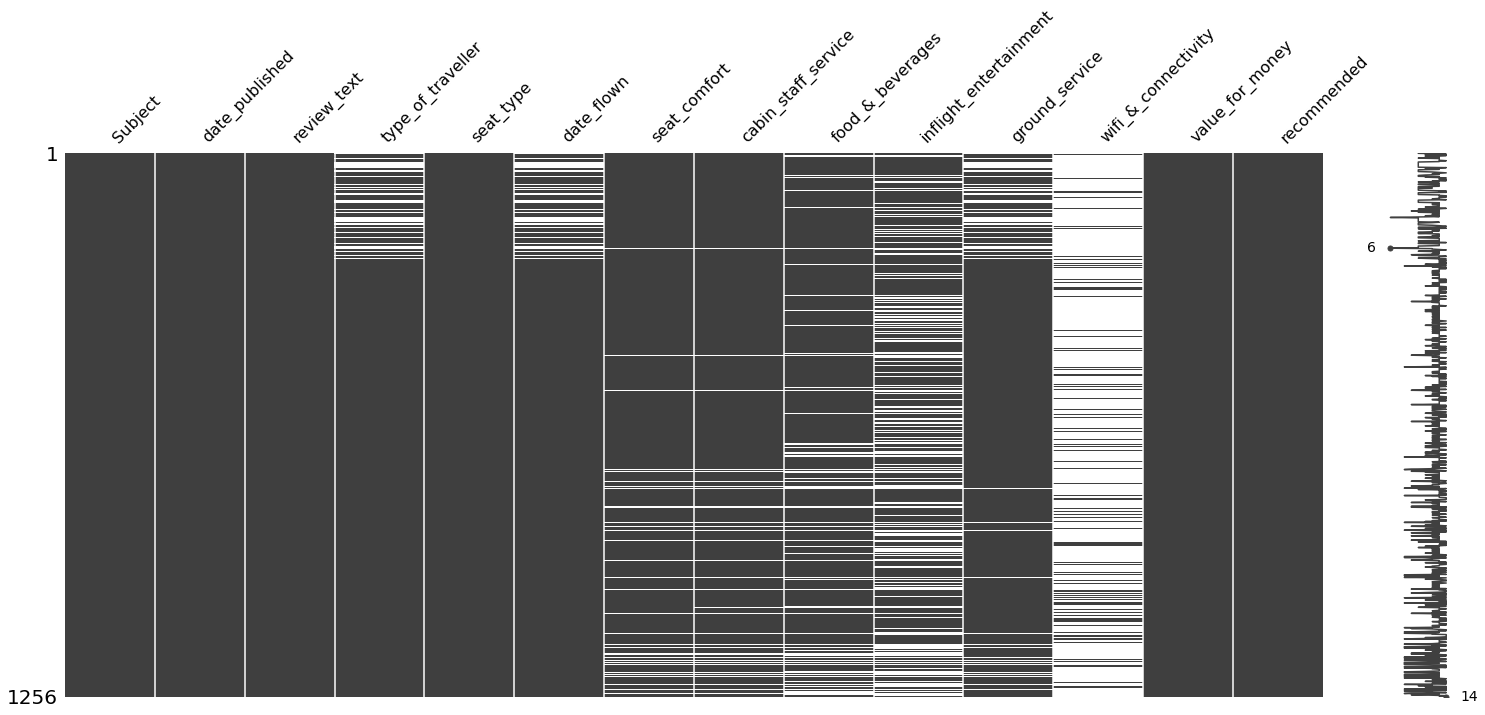

In [102]:
#Observe missingness over time
missingno.matrix(airlines_df.sort_values('date_published'))
plt.show()

From the missing value heatmap in the pandas profiling report above, we see perfect missingness correlation between *type of traveller, date flow, and route*. We also see a strong missingness correlation between *ground service* and these other variables. Since *route* has been removed, we explore reviews with the three other variables missing, looking first at the timing as the missigno plot (sorted by posting time) above suggests timing could be an important explanatory factor (i.e. the missing values for the variables of interest, happen for earlier reviews):

In [103]:
corr_missing_attrs = airlines_df[airlines_df[['type_of_traveller','date_flown','ground_service']]\
                                 .isna()\
                                 .all(axis=1)]

In [104]:
first_date = corr_missing_attrs.date_published.min()
last_date = corr_missing_attrs.date_published.max()

print(f"The review publishing dates range from {first_date} and {last_date}")

The review publishing dates range from 2015-01-01 00:05:00 and 2015-01-31 00:05:00


In [105]:
for idx, review in enumerate(corr_missing_attrs.review_text.sample(20)):
    print(str(idx) + ')',review,'\n')

0) A pleasant surprise on this MUR-TNR flight in a 340. Comfortable seats (for a 2 hours flight but in no way a lie flat) nice staff proper food and wine. Much better than my previous flight NAI-MUR where I paid business fare to be seated on a coach seat (and the crew told me it has not changed): this is why I would not recommend this airline. 

1) I had the most uncomfortable experience flying between Accra-Luanda and returning the same route. The flight was delayed and without any explanation or updates from the carrier. The cabin was very dirty and poorly maintained. The facilities were pathetic and not well serviced during the flight. Cabin crew were poorly trained or lacked customer friendliness and seemed very aloof without much concern. The overnight hotel accommodation was pathetic. Boarding procedures were woefully managed. No recognition was provided to the star tier members when checking in at the counter or when boarding. People simply pushed their way through. Given the ty

In [106]:
len(airlines_df.query(f" date_published.dt.year == 2015"))

248

The perfect correlation between the missigness of these variables occurred throughout 2015 and might point towards the site the data was extracted from: Skytrax. There doesn't appear to be any indicating factor from the reviews themselves (e.g. cancellations) that might point to why these were missing. Maybe the fields for these variables were not required as of 2015. They seem to be required now.

We could delete records from 2015, but this would drop the rows from about 1250 to 1000. I instead leave the rows as they still present significant information despite the missing values

We also note stretches of whitelines, suggesting that people who don't fill in one attribute are more likely to not fill in other attributes as well. This phenomenon is explored below:

In [107]:
missing_inflight_attrs = airlines_df[airlines_df.iloc[:,7:11].isna().all(axis=1)]

In [108]:
for idx, review in enumerate(missing_inflight_attrs.review_text.sample(20)):
    print(str(idx) + ')',review,'\n')

0) Extremely unsatisfied customers. We have been trying to rebook our flights to Kenya for the last 6 months with only one response which was on Christmas Eve of 2020 and we haven't heard anything from them ever since. We have a booked and paid for trip which we had to rebook due to covid-19 in 2020. Our trip is expected to be this April (2021), and we had supposedly received our cancelled flights in the form of a refunded 'voucher' which was never ever received from the airline. We then received (on Christmas Eve) a link to our supposedly 'new flights' which had a time frame to a payment portal from 15h00-17h30/18h00 roughly... let me reiterate, on Christmas Eve, who is checking their emails to rebook flights in such a short time frame? We then tried to access the portal that night at 19h00 and we could not access it to pay an additional fee (when this was supposed to be fully refunded I might add) for our flights in April. I have sent roughly 50 emails to the airline, and that doesn'

These long stretches appear to be flight cancellations or failed reschedulings. This makes sense as these reviewers didn't ultimately board the plane and so couldn't rate inflight attributes like seat comfort, food and beverages, etc.

### NAs for Wifi

In [ ]:
airlines_copy = airlines_df.copy()
airlines_copy['wifi_na'] = airlines_df['wifi_&_connectivity'].isna().astype('int')
airlines_copy[airlines_copy['wifi_&_connectivity'].isna()].groupby('Subject')['wifi_na'].sum()

Subject
air-algerie               11
air-mauritius             61
air-seychelles            15
comair                    32
egyptair                 142
ethiopian-airlines       262
fastjet                   27
kenya-airways            167
royal-air-maroc          126
south-african-airways    162
tunisair                  25
Name: wifi_na, dtype: int64

In [ ]:
airlines_df[airlines_df.route.isna()].query("Subject == 'air-new-zealand'")['recommended'].value_counts()

yes    48
no     37
Name: recommended, dtype: int64

Seems a lot of the reviews which had missing values for route and date flown were born out of sheer frustration. These reviewers often left out the rating of other aspects of the flight

In [ ]:
airlines_df[airlines_df.route.isna()].iloc[-2,3]

"qantas is gouging customers during a global pandemic. do not use them!! i have flights scheduled in may for myself and my daughter from the usa to sydney. we are traveling to see my son who is studying abroad. he has been recalled by his university due to the pandemic so he is returning home. as of today, qantas is announcing they are canceling all int'l flights through the end of may. they are only offering a 12-month travel credit even though they are canceling flights. with my son returning to the usa, i have no plans to travel on qantas in the next 12 months. in order to cancel my flights since i won't be using their voucher, qantas is charging a cancellation fee of $500 per ticket for the international leg and $250 per ticket for the domestic leg. so i paid $2500 for both tickets, they are canceling my flight, and they want to charge me $1500 in fees! this is terrible customer service! in a time of crisis like this, they should be doing the right thing and waive these extremely e

In [ ]:
for review in airlines_df[airlines_df['wifi_&_connectivity'].isna() == False]['review_text']:
    
    print(review,'\n')

the best airline by far. had a wonderful experience especially with the cabin crew. i never eat airplane food but this was different. the food was delicious, and frequent. provided many beverages and snacks throughout the flight. the seats were comfortable, considering i flew with economy. one fault was the temperature inside the plane. i was freezing the entire flight even with 3 blankets on me, and the ac’s off. ended up having a cold for several days after my flight. overall a good experience and will definitely fly with qatar airways again. 

cabin crew were genuinely pleasant and warm. the service was excellent. the cabin crew, especially those that attended to me were genuinely pleasant and warm. the food was good and the menu options were nice, especially for the lagos to doha leg of the trip. the other in-flight services the entertainment etc were top-class. overall i was pleased. 

the flight was on time. all cabin crew are very kind and available for every single request, the

### 6. Data Transformation & Preprocessing

In [109]:
airlines_df.head()

,Subject,date_published,review_text,type_of_traveller,seat_type,date_flown,seat_comfort,cabin_staff_service,food_&_beverages,inflight_entertainment,ground_service,wifi_&_connectivity,value_for_money,recommended
0,ethiopian-airlines,2021-01-31 00:08:00,I've flown Ethiopian Airlines a couple of time...,Business,Economy Class,August 2021,2.0,1.0,1.0,1.0,2.0,1.0,1.0,0
1,ethiopian-airlines,2021-01-06 00:08:00,Fantastic journey. Flew on a Q400 turbo prop f...,Solo Leisure,Economy Class,July 2021,5.0,5.0,5.0,5.0,5.0,NaN,5.0,1
2,ethiopian-airlines,2021-01-29 00:07:00,My children are stuck in transit in Ethiopia a...,Family Leisure,Economy Class,July 2021,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
3,ethiopian-airlines,2021-01-17 00:07:00,"Average to below average. Dirty, dated 767 on ...",Business,Economy Class,July 2021,1.0,2.0,2.0,1.0,1.0,NaN,3.0,0
4,ethiopian-airlines,2021-01-10 00:07:00,Due to cancellation of my KQ flight EBB-NBO-JN...,Solo Leisure,Business Class,June 2021,4.0,4.0,3.0,2.0,2.0,NaN,3.0,1


#### 1. Interim Preprocessing
**a. Lowering text and converting ratings to sentiment (word) categorical variables**

In [110]:
#Make copy of the dataframe for data transformation and preprocessing
transformed_df = airlines_df.copy()

#Map to convert ratings to sentiment categories
rating2category = {1.0:'Negative', 2.0:'Negative', 3.0:'Neutral', 4.0:'Positive', 5.0:'Positive'}

#Convert attribute ratings to sentiment categories: Positive, Neutral, and negative
transformed_df.iloc[:,6:13] = transformed_df.iloc[:,6:13].stack().map(rating2category).unstack()


#PREPROCESS TEXT WITH MINIMAL CLEANING – just lowercasing, leave sentences as they were
#Why? Because the packages being implemented include some preprocessing steps already
#Tampering with the sentences might influence aspect based sentiment analysis predictions
min_text_cleaning = transformed_df.copy()
min_text_cleaning.review_text = min_text_cleaning.review_text.str.lower()

In [111]:
min_text_cleaning.head(3)

,Subject,date_published,review_text,type_of_traveller,seat_type,date_flown,seat_comfort,cabin_staff_service,food_&_beverages,inflight_entertainment,ground_service,wifi_&_connectivity,value_for_money,recommended
0,ethiopian-airlines,2021-01-31 00:08:00,i've flown ethiopian airlines a couple of time...,Business,Economy Class,August 2021,Negative,Negative,Negative,Negative,Negative,Negative,Negative,0
1,ethiopian-airlines,2021-01-06 00:08:00,fantastic journey. flew on a q400 turbo prop f...,Solo Leisure,Economy Class,July 2021,Positive,Positive,Positive,Positive,Positive,NaN,Positive,1
2,ethiopian-airlines,2021-01-29 00:07:00,my children are stuck in transit in ethiopia a...,Family Leisure,Economy Class,July 2021,Negative,Negative,Negative,Negative,Negative,Negative,Negative,0


In [112]:
#Write dataframe to csv
min_text_cleaning.to_csv(f'../data/interim/airlines_categorical.csv')

**b. Lowercasing with review text preprocessing – no mapping of numeric ratings to sentiment categories**

In [113]:
#Make a copy of the original dataframe
reduced_df = airlines_df.copy()

#PREPROCESS TEXT WITH SIGNIFICANTLY MORE CLEANING
#Make review text lower case, remove stopwords, remove punctuations and remove numbers

#I do not stem or lemmatize because some sentiment analysis packages that will be utilized do 
#these in their operation

reduced_df.review_text = reduced_df.review_text.apply(clean, lowercase=True,
                                                            stopwords=True,
                                                            punct=True, 
                                                            numbers = True)


#Write dataframe to csv
reduced_df.to_csv(f'../data/interim/airlines_reduced.csv')

**c. Sentiment Mapping + Lowercasing with Stopword, Punctuation and Number Removal**

In [114]:
#PREPROCESS TEXT WITH SIGNIFICANTLY MORE CLEANING
#Make review text lower case, remove stopwords, remove punctuations and remove numbers

#I do not stem or lemmatize because some sentiment analysis packages that will be utilized do 
#these in their operation

transformed_df.review_text = transformed_df.review_text.apply(clean, lowercase=True,
                                                              stopwords=True,
                                                              punct=True, 
                                                              numbers = True)

In [115]:
transformed_df.head(3)

,Subject,date_published,review_text,type_of_traveller,seat_type,date_flown,seat_comfort,cabin_staff_service,food_&_beverages,inflight_entertainment,ground_service,wifi_&_connectivity,value_for_money,recommended
0,ethiopian-airlines,2021-01-31 00:08:00,ive flown ethiopian airlines couple times gene...,Business,Economy Class,August 2021,Negative,Negative,Negative,Negative,Negative,Negative,Negative,0
1,ethiopian-airlines,2021-01-06 00:08:00,fantastic journey flew q turbo prop khartoum a...,Solo Leisure,Economy Class,July 2021,Positive,Positive,Positive,Positive,Positive,NaN,Positive,1
2,ethiopian-airlines,2021-01-29 00:07:00,children stuck transit ethiopia ethiopian airl...,Family Leisure,Economy Class,July 2021,Negative,Negative,Negative,Negative,Negative,Negative,Negative,0


In [116]:
transformed_df.to_csv(f'../data/interim/cleaned_airlines_df.csv')

#### 2. Final Preprocessing

**a. Encoding the rating sentiment variables**

In [168]:
#Make a copy of the transformed dataframe for final preprocessing
sentiment_encoded = transformed_df.copy()

#Map to encode sentiment categories
sentiment_encoder = {'Negative':0, 'Neutral':1, 'Positive':2}

#Encode sentiment categories, retaining the NAs
sentiment_encoded.iloc[:,6:13] = sentiment_encoded.iloc[:,6:13].stack()\
                                                               .map(sentiment_encoder)\
                                                               .unstack()

In [169]:
sentiment_encoded.head()

,Subject,date_published,review_text,type_of_traveller,seat_type,date_flown,seat_comfort,cabin_staff_service,food_&_beverages,inflight_entertainment,ground_service,wifi_&_connectivity,value_for_money,recommended
0,ethiopian-airlines,2021-01-31 00:08:00,ive flown ethiopian airlines couple times gene...,Business,Economy Class,August 2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,ethiopian-airlines,2021-01-06 00:08:00,fantastic journey flew q turbo prop khartoum a...,Solo Leisure,Economy Class,July 2021,2.0,2.0,2.0,2.0,2.0,NaN,2.0,1
2,ethiopian-airlines,2021-01-29 00:07:00,children stuck transit ethiopia ethiopian airl...,Family Leisure,Economy Class,July 2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,ethiopian-airlines,2021-01-17 00:07:00,average average dirty dated route entertainme...,Business,Economy Class,July 2021,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0
4,ethiopian-airlines,2021-01-10 00:07:00,due cancellation kq flight ebbnbojnb booked la...,Solo Leisure,Business Class,June 2021,2.0,2.0,1.0,0.0,0.0,NaN,1.0,1


In [170]:
sentiment_encoded.to_csv(f'../data/processed/partial_encoding.csv')